# Social synchronization of conditioned fear in mice requires ventral hippocampus input to amygdala
Running title: Emotional synchronization in mice<BR>
Wataru Ito*, Alexei Morozov*

This document describes the codes in the manuscript and how to run them using an example video.
    
# Set up the Python environment
Conda and pip configured the Python environment. We describe here installation only on Windows 10 PC. The lines preceded by # are comment lines. The installation procedure was tested on 11/10/2021 using a freshly installed Win10 PC, version 20H2, which does not contain any non-standard hardware. Typical install time is about less than one hour with introductory knowledge on Win10 operating system, python, conda, pip and GitHub. Reproducing result from an example video requires introductory knowledge on Jupyter Notebook or Lab.

#### 1. Install Windows apps
1. Miniconda<BR>
Download the binary and install it as described on the web<BR>
https://docs.conda.io/en/latest/miniconda.html#windows-installers
2. node.js<BR>
Download Nodo.js from https://nodejs.org/en/download/
3. ffmpeg<BR>
    a) Download ffmpeg-git-full.7z from https://www.gyan.dev/ffmpeg/builds/<BR>
    b) Move the folder `ffmpeg-2021-11-07-git-45dc668aea-full_build` to `C:\Program Files`.<BR>
    (The folder name might be different depending the timing of download.)<BR>
    c) Set the system path.<BR>
    Click `Windows Start button` and type "env". Click the `Edit the system environment variables`.<BR>
    
    <img src="img/Screenshot 2021-11-10 170410.png" width=200px><BR>
    
    Click `Environment Variables...`.<BR>
    
    <img src="img/Screenshot 2021-11-10 170711.png" width=300px><BR>
    
    Select "Path" in the lower "System variables" panel and Click `Edit...`<BR>

    <img src="img/Screenshot 2021-11-10 171038.png" width=300px><BR>
    
    Click `New` and enter the path as shown below.<BR>
    
    <img src="img/Screenshot 2021-11-10 141544.png" width=300px><BR>   
    
#### 2. Open the Anaconda prompt and follow the sequence below.
1. In the Anaconda prompt

```python
# anaconda, python 3.8 for MATLAB engine for python
conda update -n base -c defaults conda
conda create --name jl2
conda activate jl2
conda install python=3.8 anaconda
```

```python
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install jupyter-matplotlib
jupyter nbextension list
```

```python 
# Install other packages for video process
pip install opencv-contrib-python
pip install ffmpeg-python
```

#### 3. Download the codes and start Jupyter Lab
1. Go to https://github.com/wataruito/Codes_in_Emotional_sync_Ito_et_al
2. Select the "Code/Download ZIP"<BR>
    
<img src="img/Screenshot 2021-11-10 145736.png" width=400px><BR>
    
3. Extract the downloaded zip file.
4. Place the `Codes_in_Emotional_sync_Ito_et_al-main` folder to an appropriate place.


#### 4. In the opened the Anaconda prompt   
1. Change the current directory into the `Codes_in_Emotional_sync_Ito_et_al-main` folder.
2. Start Jupyter Lab.
    
```python
jupyter lab python_codes_in_manuscript.ipynb
```
    
Follow "1. Set the root path" in the opened notebook. Execution of each cell takes less than a second. 

---
# 1. Set the root path
Set the current path as an absolute path.

In [1]:
# You need to specify current path as the root path.
# If you put the "Codes_in_Emotional_sync_Ito_et_al-main" folder in C:/Users/User,
# root_path = r'C:\Users\User\Codes_in_Emotional_sync_Ito_et_al-main'

root_path = r'W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al'

# 2. Convert Freezeframe video to mp4 format
#### 1. Export AVI file using FreezeFrame Viewer
    1) install FreezeFrameInstaller4104.zip
    2) in FreezeFrame Viewer
        Video/Compress Image Files, as AVI file, using MJPEG Compressor
#### Or copy `m7ab.avi` file from `videos_processed\exp1` to `videos\exp1`
`videos_processed\exp1` folder contains all processed data analyzed by the following python scripts.

#### 2. Convert avi to mp4
The following script rotates and converts all AVI videos inside the specified folder.

In [2]:
# Specify Windows path of the folder, which has the exported avi files.
r_path = r'videos\exp1'

import os
import ffmpeg

path = os.path.join(root_path, r_path)
os.chdir(path)
print(os.listdir(path))

for file in os.listdir(path):
    base = os.path.splitext(file)[0]
    extn = os.path.splitext(file)[1]
    if extn == '.avi':
        # !ffmpeg -i {file} -vf "transpose=2,transpose=2" -vcodec libx264 {base}.mp4
        fileIN = os.path.join(path,file)
        print('file = ', fileIN, end = ' ')
        stream = ffmpeg.input(fileIN)
        stream = ffmpeg.hflip(stream)
        stream = ffmpeg.vflip(stream)
        fileOUT = os.path.join(path,base) + '.mp4'
        print('---> output = ', fileOUT)
        stream = ffmpeg.output(stream, fileOUT, vcodec='libx264')
        ffmpeg.run(stream)
print('end')

['m7ab.avi']
file =  W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al\videos\exp1\m7ab.avi ---> output =  W:\wataru\jupyter\synchro_freeze\Codes_in_Emotional_sync_Ito_et_al\videos\exp1\m7ab.mp4
end


In this case, it generates `videos\exp1\m7ab.mp4`.

# 3. Manual annotation of videos for the onset and offset of freezing 

Videoplay is designed as an interactive video annotator through keyboard inputs. For example, a user can move forward and backward the movie frames, select the target subject to be annotated, and mark the start and end video frames for each freezing bout.  

**Short description of keyboard controls:**
```
<Video control>
w: start palying
s: stop playing
a: step back a frame
d: step forward a frame
A: step back <frame_jump> frames
D: step forward <frame_jump> frames
~: set <frame_jump> parameter
q: increase playback speed
e: decrease playback speed

<Tracking trajectories>
0: drug mode
1: sub1 click mode
2: sub2 click mode

<Annotate freezing>
!: set target sub1
@: set target sub2
j: start freezing
k: end freezing
    
<Quit>
Esc
````



In [3]:
import videoplay as vp

# Specify Windows path of the MP4 movie file.
r_path = r'videos\exp1\m7ab.mp4'
path = os.path.join(root_path, r_path)

vp.video_cursor(path,3)

Video resolution: (236, 304, 3)
total frame number: 722
	Writing _m7ab_track_freeze.csv
	Writing _m7ab_freeze.csv


After quitting Videoplay by Esc key, it generates `videos\exp1\_m7ab_track_freeze.csv` and `videos\exp1\_m7ab_freeze.csv`.

# 4. Manually modify the output CSV files from Videoplay
The Videoplay outputs a csv file, `videos\exp1\_m7ab_freeze.csv`. If you complete the annotation for the entire movie, it looks as follows. If you want to skip the annotation by yourself, simply copy `videos_processed\exp1\_m7ab_freeze.csv`.<BR>
    
<img src="img/Screenshot 2021-11-10 174415.png" width=300px><BR>

Modify the csv file  manually as below and save as `videos\exp1\m7ab.csv`.
       
<img src="img/Screenshot 2021-11-10 175024.png" width=400px><BR>

# 5. Compute freezing duration for each animal and freezing overlap for each dyad.

The following script processes all csv files inside the specified folder (Here, you have only one csv file).
The root folder `videos` can contain multiple experiment folders, `exp1`, `exp2` .... Each experiment folder
contains the CSV files, including the freezing onset and offset for two subjects as described in 4.

In [4]:
import synchro_freeze as sf
import traceback
import os

# Specify Windows path of the parent folder for experiments.
r_path = r'videos'
path = os.path.join(root_path, r_path)

DEBUG = False
df = sf.process_freeze(path,DEBUG)

Step1. Reading CSV files from subfolders.
	Processing directory:  exp1,  completed.
	Writing summary.csv.
Step2. Reading trajectory CSV files from subfolders.
	Processing directory:  exp1,  completed.
	Writing summary_traj.csv.
Step3. Computing % epoch time.
	Writing summary1.csv.
Step4. Computing permutation/Cohen_D and store in DF.
	Processing column:  0/1,  completed.
	Writing summary2.csv.


The script generates `videos\summary2.csv` that is the final output. The format is as follows.

|folder_videoname|single_animal|video_system|video_total_frames|fz_start_sub1|fz_end_sub1|fz_start_sub2|fz_end_sub2|fz_sub1|fz_sub2|fz_overlap|cohen_d|
|---|---|---|---|---|---|---|---|---|---|---|---|
|str|bool|str|int|int array|int array|int array|int array|float|float|float|float|

|column label|description|
|-|-|
|fz_start_sub1, fz_start_sub2|freezing onset frame number|
|fz_end_sub1, fz_end_sub2|freezing offset frame number|
|fz_sub1, fz_sub2|% freezing time|
|fz_overlap|% freezing overlap time|
|cohen_d|Cohen's D effect size|

# 6. Display freezing overlap
#### 1. Identify the folder ID.

In [5]:
print("We found the following Foldername_videoname.\n")
for i in range (0, len(df)):
    print("\t", i, df.iloc[i,0])

print("\nSelect the Foldername_videoname ID number and run the next cell")

We found the following Foldername_videoname.

	 0 exp1_m7ab

Select the Foldername_videoname ID number and run the next cell


#### 2. Set the number left next the "exp1_m7ab" as folderID, and draw the graph.

Folder name: exp1_m7ab
Animal1 freeze : 21.250000
Animal2 freeze : 51.041667
Overlap freeze : 19.791667


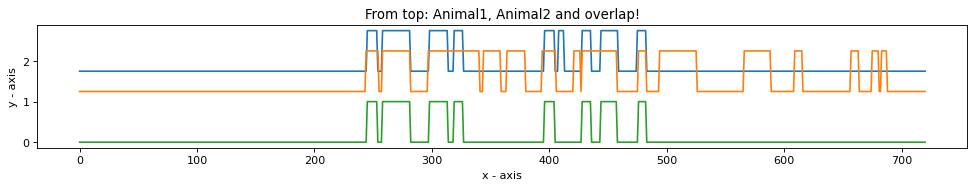

In [6]:
folderID = 0
output = True
video_system = 'FreezeFrame'

(a,b,c,d) = sf.overlap_freezing(df.iloc[folderID,:], path, output)

From the top to bottom, the freezing timelines from Animal1, Animal2 and Overlap. x - axis is in sec.<BR>
This script also generate eps file, `videos\exp1\overlap_fig.eps`. You can use for making figures.